# CRF model

$$
\newcommand\EE{\mathbb E}
\newcommand\RR{\mathbb R}
\newcommand\PP{\mathbb P}
$$

We consider the input image $I$ to be a graph $V$ with each node $v$ carrying pixel data (RGB). Then we can see about downsampling using e.g. SLIC.

We want to classify each node $v$ as foreground ($1$) or background ($-1$). For this, we will use a conditional random field (CRF) model specified over the nodes: the label likelihood factors as logistic regression given a latent variable $Z_v$ at node $v$:
$$
    p(l_v|Z_v;\theta) = g(l_v\theta^\intercal Z_v)\quad
    \text{where}\ g(u) = \frac{e^u}{e^u + 1}
$$
and $\theta$ is a parameter vector we learn over the set of examples.

The data likelihood is given by
$$
    \mathcal L(\theta; I) = \log\left(
        \sum_Z p(l|Z;\theta) p(Z|I)
    \right) =
    \log\left(\sum_Z \left[ \prod_{v\in V} 
            g(l_v\theta^\intercal Z_v)\right] p(Z|I)
    \right)
$$

In [1]:
%load_ext autoreload
%autoreload 2
import os
os.chdir("../")

import matplotlib.pyplot as plt
import cv2
import numpy as np

plt.rcParams['figure.dpi'] = 90

import glob

IMAGE_FOLDER = "data/train/images"
MASKS_FOLDER = "data/train/masks"

IMAGES = sorted(glob.glob(os.path.join(IMAGE_FOLDER, "*.jpg")))
MASKS = sorted(glob.glob(os.path.join(MASKS_FOLDER, "*.png")))

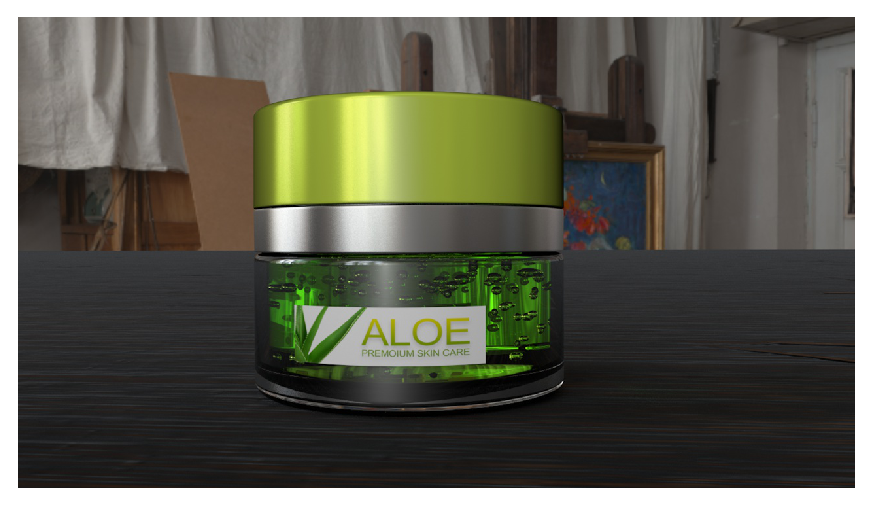

In [2]:
## Load an image
img = cv2.imread(IMAGES[15])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = cv2.imread(MASKS[15])

plt.imshow(img)
plt.axis('off');

## Smart downsampling with SLIC

In [3]:
from fast_slic.avx2 import SlicAvx2

In [4]:
slic = SlicAvx2(num_components=2000, compactness=40)

In [5]:
assignments = slic.iterate(img)

In [6]:
from skimage import color
from skimage.segmentation import mark_boundaries

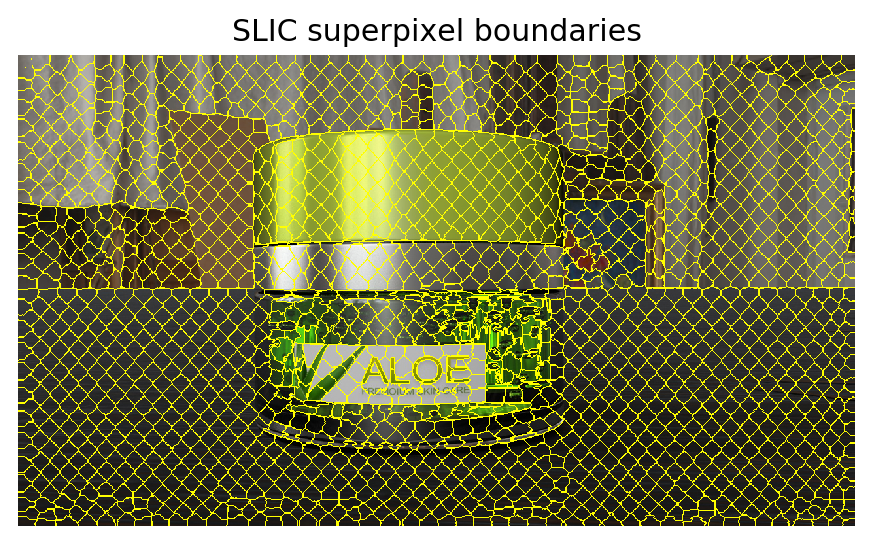

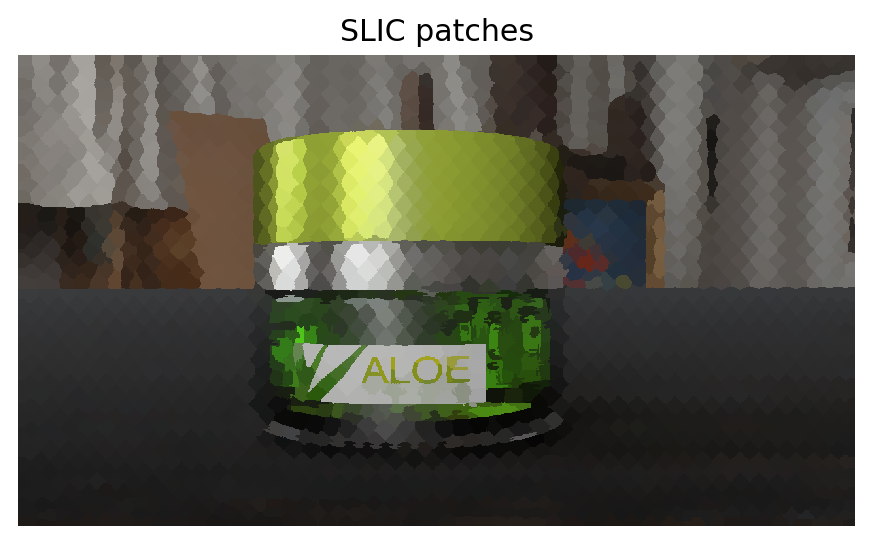

In [7]:
img_slic_boundaries = mark_boundaries(img, assignments)
img_slic = color.label2rgb(assignments, img, kind='avg')

plt.figure()
plt.title("SLIC superpixel boundaries")
plt.imshow(img_slic_boundaries)
plt.axis('off')

plt.figure()
plt.title("SLIC patches")
plt.imshow(img_slic)
plt.axis('off');

Now, we want to infer the labels of the SLIC cluster graph nodes.

In [12]:
## Recover the neighbors of each node
from utils.graph import get_slic_graph, get_node_mask

In [13]:
nodes, neighbors = get_slic_graph(slic, assignments)

In [14]:
mask_nodes = get_node_mask(mask, nodes)

In [40]:
from skimage import filters as skfil

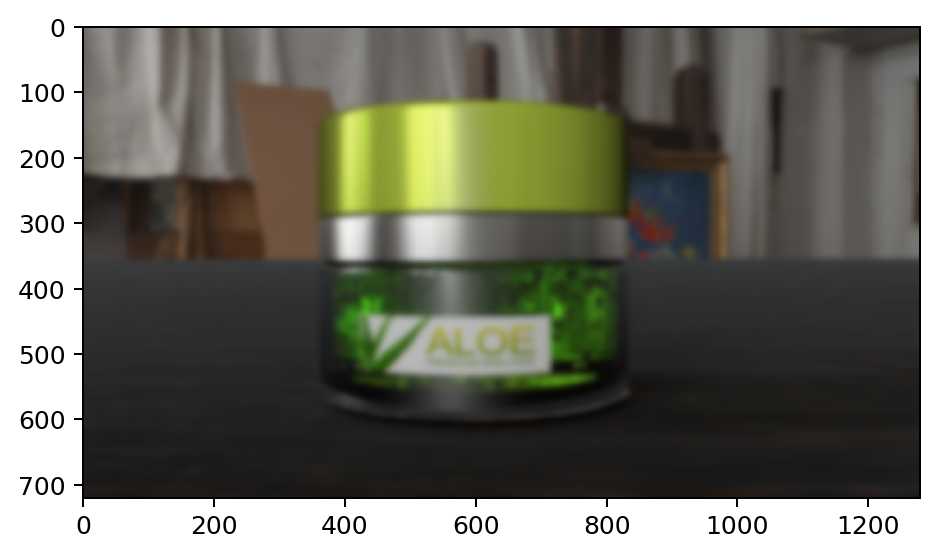

In [89]:
img_gauss = (skfil.gaussian(img, sigma=5, multichannel=True) * 255).astype(np.uint8)
plt.imshow(img_gauss)

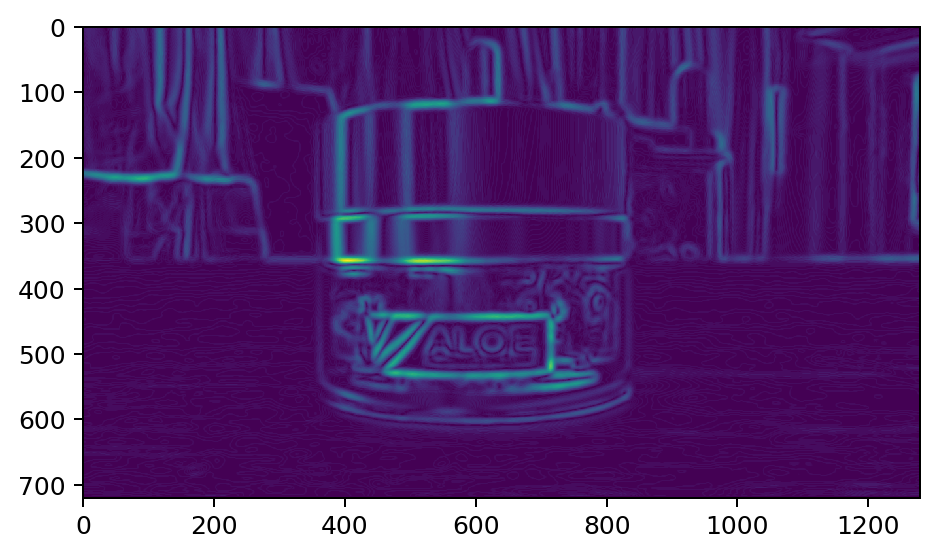

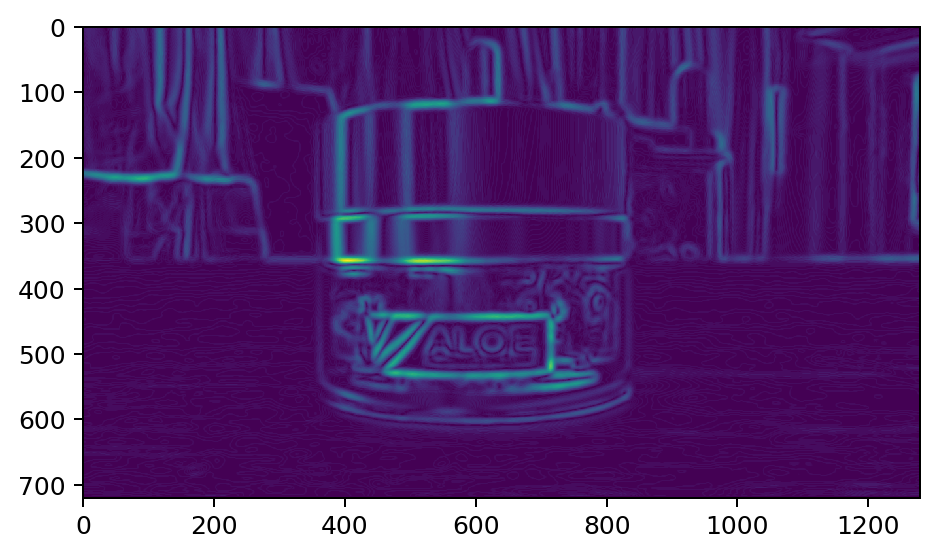

In [221]:
img_prewitt = skfil.prewitt(cv2.cvtColor(img_gauss, cv2.COLOR_RGB2GRAY))

plt.imshow(img_prewitt)

plt.figure()
img_laplace = (img_prewitt - img_prewitt.min()) / (img_prewitt.max() - img_prewitt.min())
plt.imshow(img_prewitt)

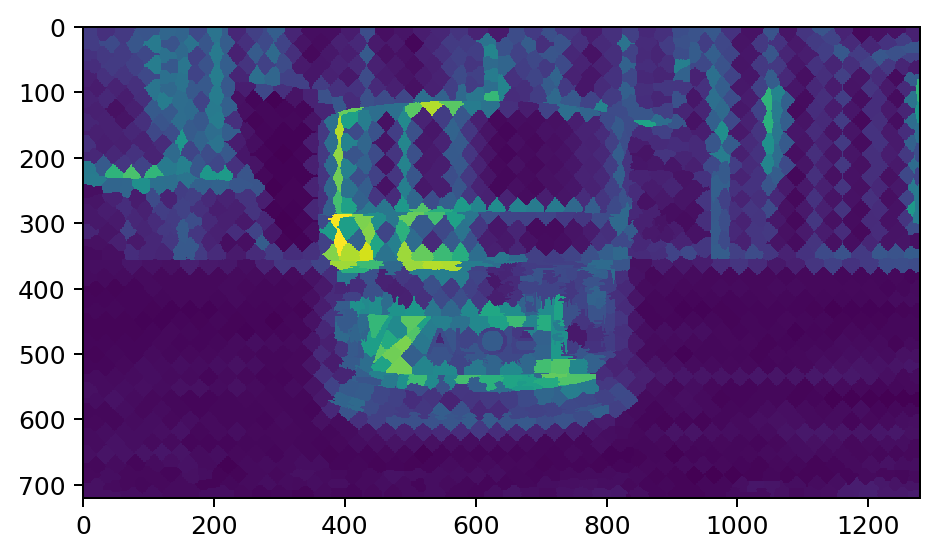

In [222]:
prewitt_slic = color.label2rgb(assignments, img_prewitt, kind='avg')
plt.imshow(prewitt_slic)

In [223]:
prewitt_nodes = np.zeros(len(nodes))
prewitt_nodes[assignments] = prewitt_slic

## Conditionally deterministic $Z$

Let's define the latent variable $Z$ to be a deterministic feature function of the node data $X$.

In this case, the likelihood function collapses to
$$
    \mathcal L(\theta; X) = \log\left(
        p(l|Z;\theta) p(Z|X)
    \right) =
    \sum_{v\in V} 
    \log g(\theta^\intercal Z_v)
    + \log p(Z|X)
$$

In [224]:
from utils.graph import fill_from_assignments, rebuild_mask
from utils.graph import get_laplacian

In [225]:
# Assemble features
colors_arr = np.asarray([node['color'] for node in nodes])
Z1 = get_laplacian(nodes, neighbors, weighted=True)
Z_bis = get_laplacian(nodes, neighbors, data=Z1, weighted=True)  # bi-laplacian
Z3 = get_laplacian(nodes, neighbors, data=Z_bis, weighted=True)

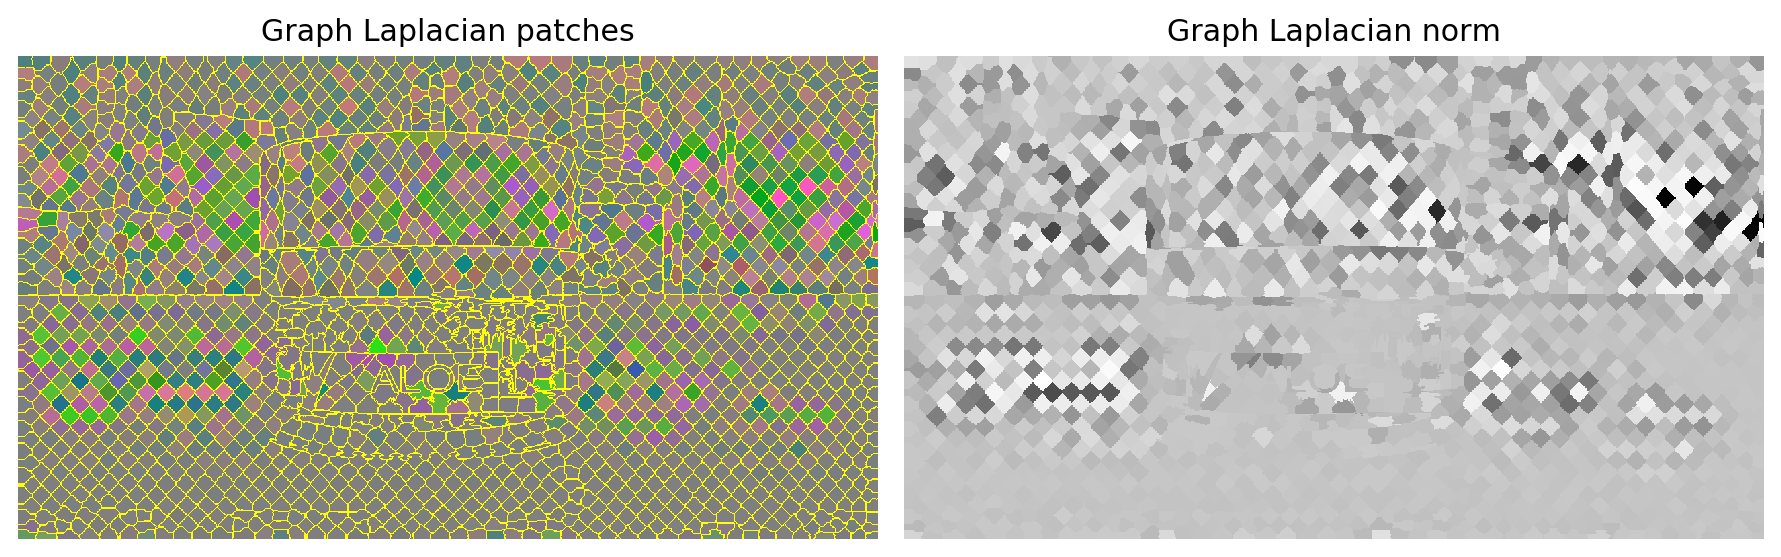

In [226]:
Z_img = fill_from_assignments(assignments, Z1)
Z_img = (Z_img - Z_img.min())/(Z_img.max() - Z_img.min())
Z_norm_img = np.linalg.norm(Z_img, axis=2)

plt.figure(figsize=(10,6))
Z_img = mark_boundaries(Z_img, assignments)  # add separation lines
plt.subplot(121)
plt.title("Graph Laplacian patches")
plt.imshow(Z_img)
plt.axis('off');

plt.subplot(122)
plt.title("Graph Laplacian norm")
plt.imshow(Z_norm_img, cmap="Greys")
plt.axis('off');
plt.tight_layout()

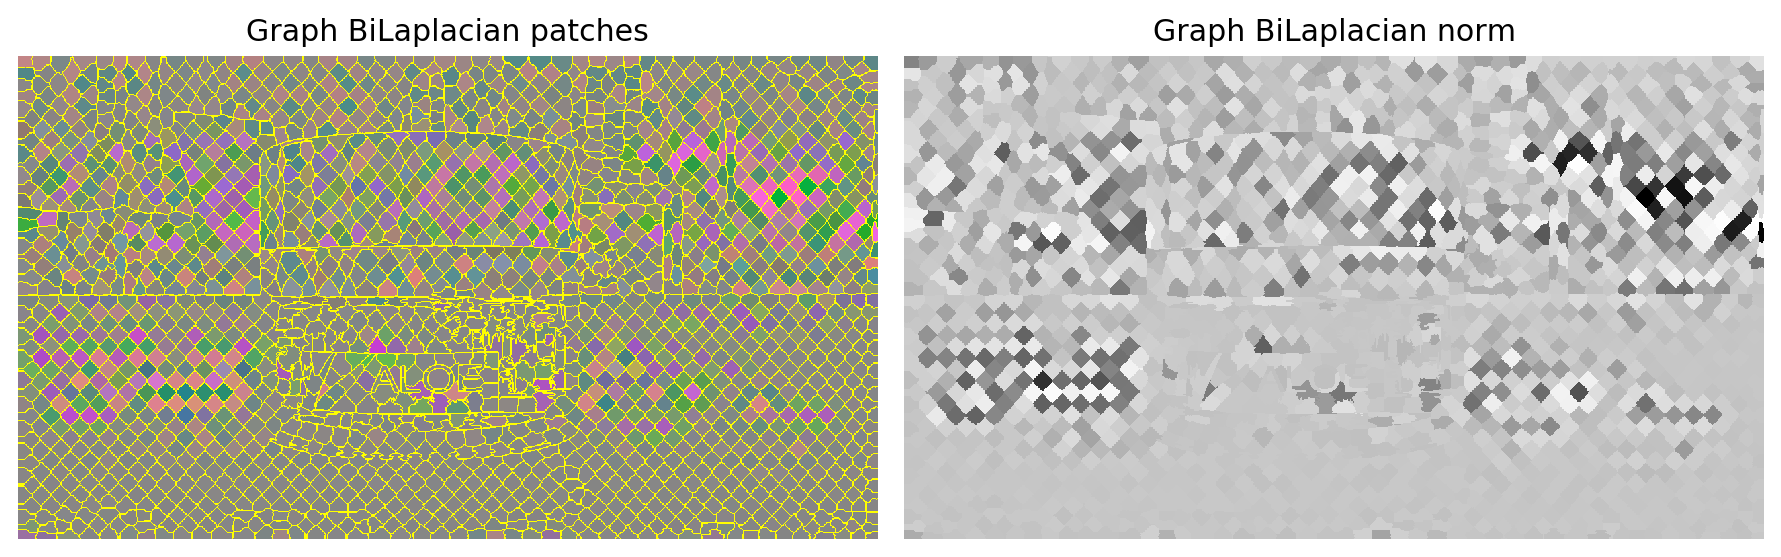

In [227]:
## Same thing with bi-laplacian
Z_bis_img = fill_from_assignments(assignments, Z_bis)
Z_bis_img = (Z_bis_img - Z_bis_img.min())/(Z_bis_img.max() - Z_bis_img.min())
Z_bis_norm_img = np.linalg.norm(Z_bis_img, axis=2)

plt.figure(figsize=(10,6))
plt.subplot(121)
Z_bis_img = mark_boundaries(Z_bis_img, assignments)  # add separation lines
plt.title("Graph BiLaplacian patches")
plt.imshow(Z_bis_img)
plt.axis('off');

plt.subplot(122)
plt.title("Graph BiLaplacian norm")
plt.imshow(Z_bis_norm_img, cmap="Greys")
plt.axis('off');
plt.tight_layout()

We then assemble the complete feature vector:

In [228]:
Z = np.hstack([colors_arr,
               #Z1,
               #Z_bis,
               #Z3,
               prewitt_nodes[:, None]
              ])
Z.shape

(2000, 4)

### Computing the MLE

In [229]:
from scipy.special import expit
# for now, use the scipy optimize API
from scipy.optimize import minimize

from sklearn.metrics import accuracy_score
from utils.metrics import dice_score

In [230]:
def compute_mle(labels, Z):
    EPSILON = 1e-60
    def objective(theta):
        return -np.sum(np.log(expit(labels * Z @ theta) + EPSILON))

    def gradient(theta):
        weights = expit(-labels * Z @ theta)[:, None]
        return -np.sum(labels * weights * Z, axis=0)
    
    prog = minimize(objective, np.random.rand(Z.shape[1]), jac=gradient)
    return prog

In [231]:
labels = mask_nodes[:, None] * 2 - 1

In [232]:
res = compute_mle(labels, Z)

In [233]:
print(res.message)
print("Success:", res.success)
print("Theta:", res.x)
res.fun

Optimization terminated successfully.
Success: True
Theta: [ 1.11456973e-02 -1.31859143e-01  1.12992563e-01 -1.14191019e+02]


619.556745287431

In [234]:
def predict(theta):
    """Predict node label=1 probability."""
    return expit(Z @ theta)

In [235]:
prob_predict = predict(theta=res.x)

In [236]:
labels_predict = (prob_predict > .5).astype(int) * 2 - 1

In [ ]:
plt.imshow(fill_from_assignments(assignments, prob_predict), cmap='Greys')

In [237]:
mask_predict = rebuild_mask(img, assignments, labels_predict)

In [238]:
print("Accuracy:\t%.2f" % (100*accuracy_score(labels, labels_predict)))
print("Dice score:\t%.4f" % dice_score(mask, mask_predict))

Accuracy:	88.65
Dice score:	0.1931


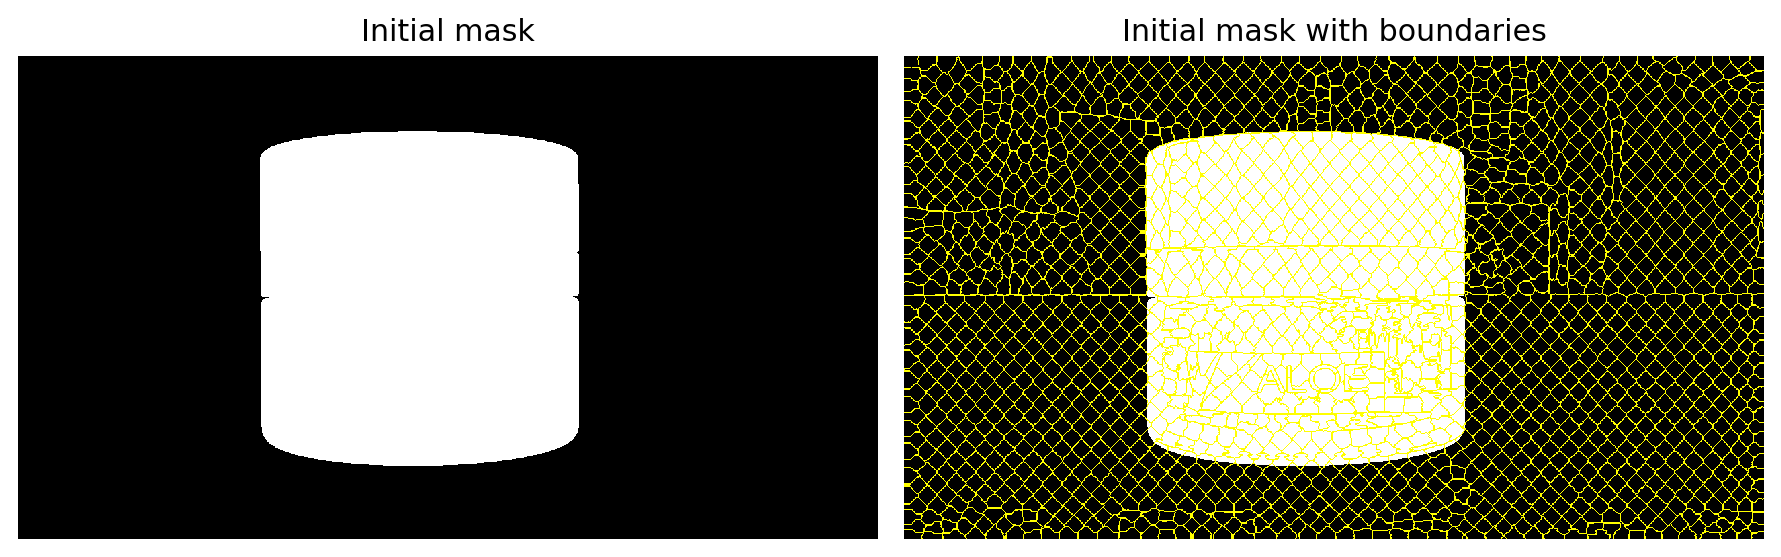

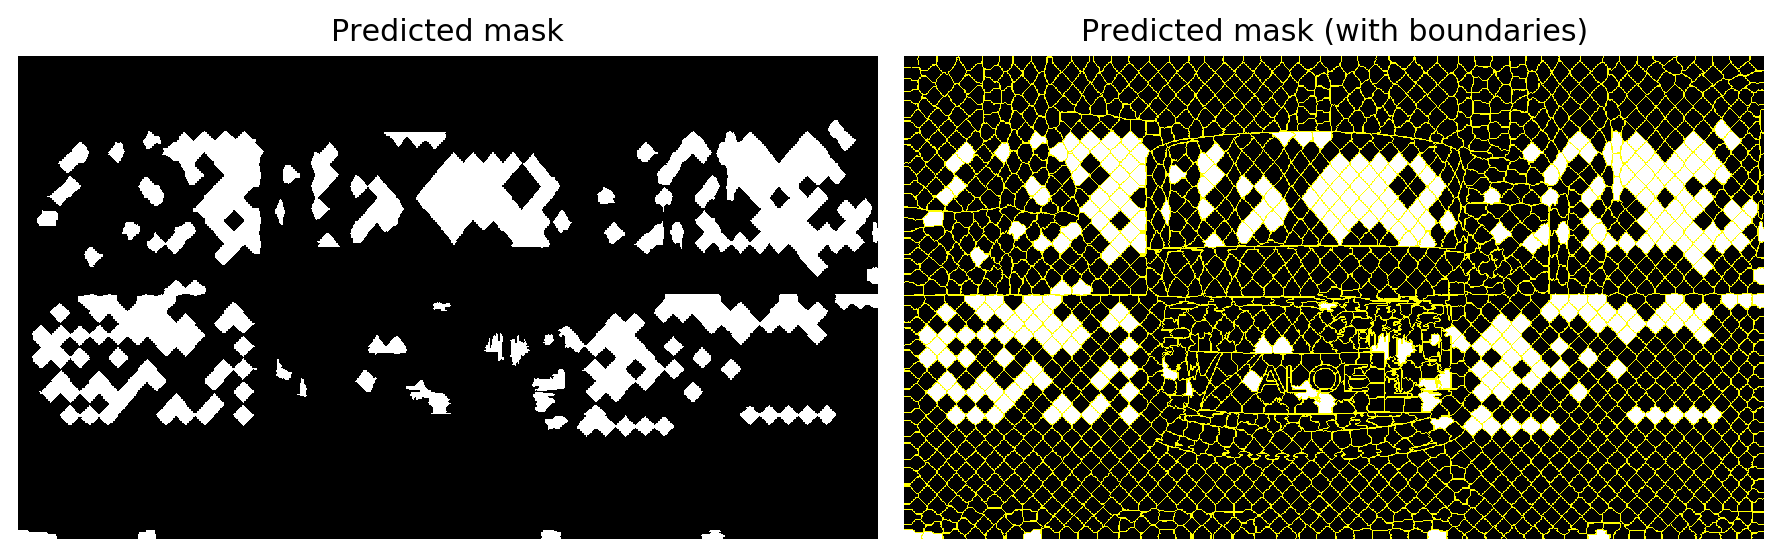

In [239]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.title("Initial mask")
plt.imshow(mask)
plt.axis('off')

plt.subplot(122)
plt.title("Initial mask with boundaries")
plt.imshow(mark_boundaries(mask, assignments))
plt.axis('off')
plt.tight_layout()

plt.figure(figsize=(10, 5))
mask_predict_boundaries = mark_boundaries(mask_predict, assignments)
plt.subplot(121)
plt.title("Predicted mask")
plt.imshow(mask_predict)
plt.axis('off')
plt.subplot(122)
plt.title("Predicted mask (with boundaries)")
plt.imshow(mask_predict_boundaries)
plt.axis('off')
plt.tight_layout()

## Stochastic latent $Z$: Ising style

## Stochastic latent $Z$: Gaussian process

We change the model spec: now $Z$ is a Gaussian process of mean function $\mu(x,y) = \theta^\intercal f(x,y)$ for the features $f$ and covariance some kernel $k$.
$$
    p(l_v|Z,X;\theta) = \Phi(l_v Z(x_v,y_v))
$$

The observed data likelihood becomes an $|V|$-dimensional integral over the values of $Z$ at the nodes
$$
    p(l|X;\theta) = \int_{\mathbb R^V} \prod_{v\in V} \Phi(l_v Z_v) dp(Z|X)
$$
where $Z | X \sim\mathcal N(\theta^\intercal\mathbf f, \mathbf K)$ with $\mathbf K = [k((x_v,y_v),(x_w,y_w))]_{v,w\in V}$.

In [34]:
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

In [35]:
kernel_ = RBF(length_scale=60)

In [36]:
pos_matrix = np.array([v['yx'] for v in nodes])

In [37]:
ker_matrix = kernel_(pos_matrix, pos_matrix)

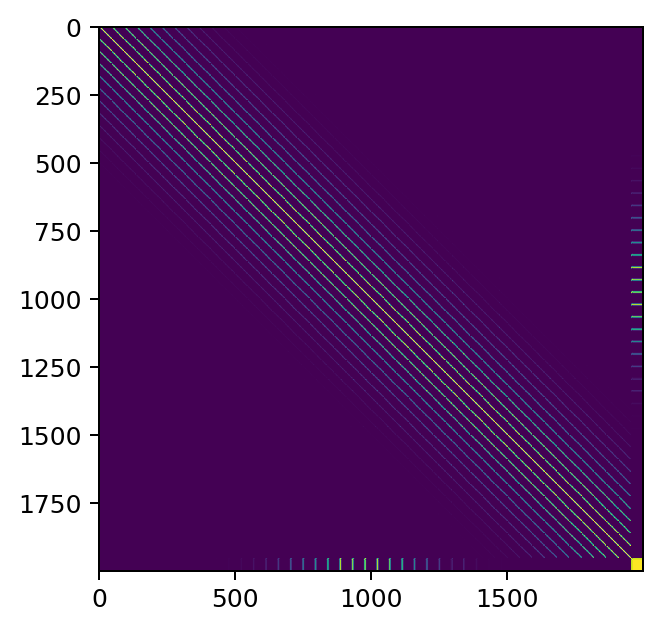

In [38]:
plt.imshow(ker_matrix)

To compute the MLE $\hat\theta$, we need to design an EM algorithm.

The log-likelihood is
$$
    \log p(l|X;\theta) = \log\left(
    \int_{\mathbb R^V} \prod_v \Phi(l_vZ_v) p(Z|X) dZ
    \right)
$$

Let $q(Z)$ be a variational distribution over $\RR^V$. By Jensen
$$
    \log p(l|X;\theta) = \log\left(\int_{\RR^V} \prod_v \Phi(l_vZ_v)  \frac{p(Z|X)}{q(Z)} q(Z) dZ \right) \geq \mathscr L(q,\theta)
    := \int_{\RR^V} \left(\sum_{v\in V} \log \Phi(l_vZ_v) q(Z) \right) \log\frac{p(Z|X)}{q(Z)} dZ
$$